In [1]:
import pickle
import time
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

cur_dir = os.getcwd()
main_dir = os.path.dirname(os.path.dirname(cur_dir))

# Investigate the PZT data

In [6]:
data_dir = os.path.join(main_dir, "ConsolidatedData", "Training1_Jan2023")
filename = "consolidated_pzt_1.pkl"
# filename = "consolidated_repeated_sg_0.pkl"
# filename = "videotimed_labeled_consolidated_all.pkl"
file_path = os.path.join(data_dir, filename)
with open(os.path.join(file_path),'rb') as f:
  data = pickle.load(f)

In [7]:
data.shape

(55358000, 7)

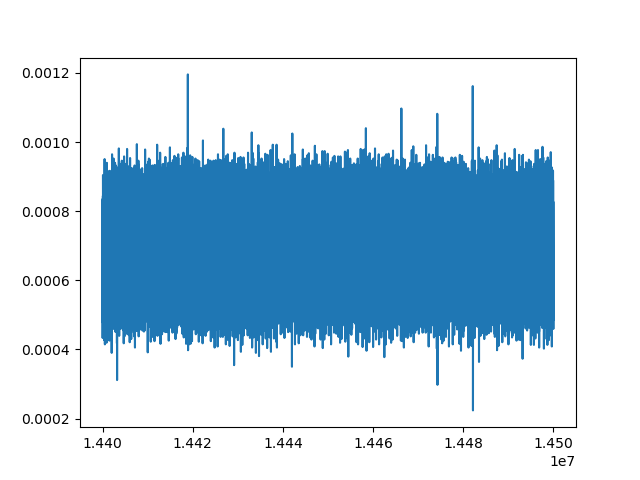

In [18]:
pzt_data = data
last_phase_pzt1 = pzt_data.iloc[14400000:14400000+100000]["PZT 1"]
plt.plot(last_phase_pzt1)

## Examine the SG/RTD Data

In [ ]:
#Experiments to shed light on the time delta between RTD&SG and PZTs
#Check for big time jumps in SG/RTD timestamps that we cannot explain.

data_dir = os.path.join(main_dir, "ConsolidatedData", "Training1")
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  training_df = pickle.load(f)
cur_dir = os.getcwd()
main_dir = os.path.dirname(os.path.dirname(cur_dir))

test_date = "08_02_2022"
test_folder = "Day2_Training1"
rtdstr_filename = "compensated_normalized_WTRUN2_day2_training1_2022-08-02_12-38-30-01_rtd-str.csv"
data_dir = os.path.join(main_dir, test_date+"_Tests", "testdata", test_folder)
file_csv = os.path.join(data_dir, rtdstr_filename)
training_df = pd.read_csv(file_csv, header=0)

rtdstr_times = training_df["Date/Time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d_%H-%M-%S-%f"))
rtdstr_times = rtdstr_times.apply(lambda x: datetime.datetime(1900, 1, 1, x.hour, x.minute, x.second, x.microsecond)) #We do this because we haven't recorded date in the original data.
training_df.insert(1, "rtdstr_DateTime Obj", rtdstr_times)


#Look at the time passed at each test run in RTD/SG data.
t1 = training_df["rtdstr_DateTime Obj"].iloc[1964089] - training_df["rtdstr_DateTime Obj"].iloc[0]
t2 = training_df["rtdstr_DateTime Obj"].iloc[-1] - training_df["rtdstr_DateTime Obj"].iloc[1964090]
time = t1+t2
time_seconds = t1.total_seconds()
print (time_seconds)

#See if there's any big time jump that we cannot quite explain.
training_df.insert(2, "Time Diff", None)
training_df['shifted_rtdstr_DateTime Obj'] = training_df['rtdstr_DateTime Obj'].shift(-1)
training_df["Time Diff"] = training_df["shifted_rtdstr_DateTime Obj"] - training_df["rtdstr_DateTime Obj"]
training_df[training_df["Time Diff"] > datetime.timedelta(0,0,100000)]

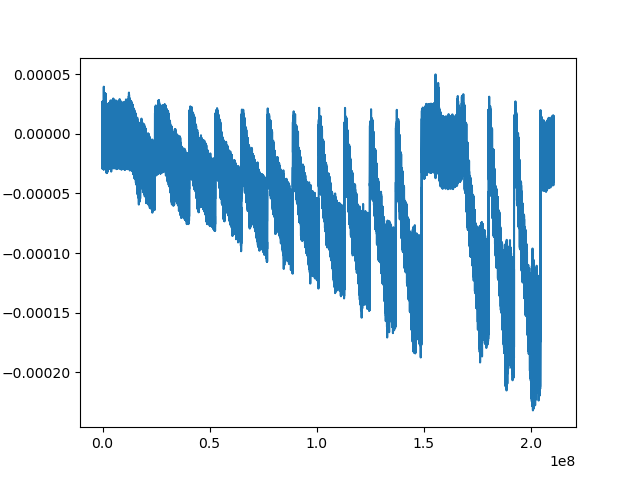

: 

In [17]:
%matplotlib widget
data_dir = os.path.join(main_dir, "ConsolidatedData", "Training1_Jan2023")
with open(os.path.join(data_dir,'consolidated_repeated_sg_all.pkl'), 'rb') as f:
  df = pickle.load(f)

plt.plot(df["SG 1 (V) (normalized) (compensated)"])

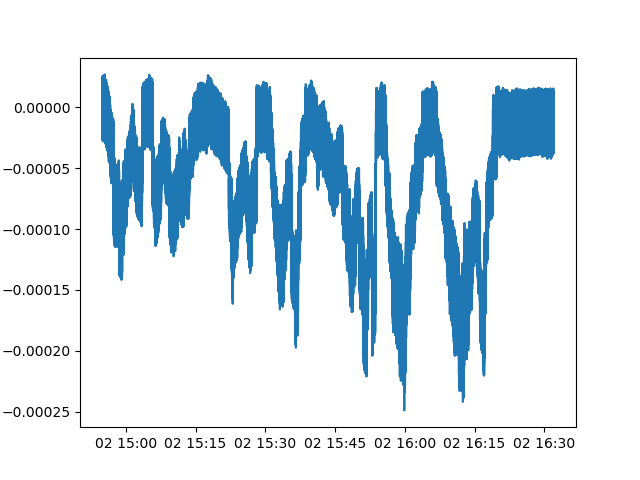

In [20]:
%matplotlib widget
data_dir = os.path.join(main_dir, "ConsolidatedData", "Dynamic1_Jan2023")
with open(os.path.join(data_dir,'videotimed_labeled_consolidated_all.pkl'), 'rb') as f:
  df = pickle.load(f)

plt.plot(df["rtdstr_DateTime Obj"], df["SG 1 (V) (normalized) (compensated)"])

# Investigate Training Data

## Investigate the concatenated data from multiple dfs

In [2]:
data_dir = os.path.join(main_dir, "MLmodels", "Training1_Jan2023", "data")
# data_dir_b = os.path.join(main_dir, "MLmodels", "Training1_B", "data")

multidf_data = np.load(os.path.join(data_dir, "sttr_aug2022_data_multidf.npy"))
# multidf_data_noncomp = np.load(os.path.join(data_dir, "sttr_aug2022_data_multidf_noncomp.npy"))
# multidf_data_b = np.load(os.path.join(data_dir_b, "sttr_aug2022_data_singledf.npy"))
# state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))

stackedAllExamples_multidf = np.transpose(multidf_data[:,:,0:299600], (1,0,2)).reshape(14, -1) #For usual compensated data (take first 30 seconds to match with dataset B)
# stackedAllExamples_multidf_noncomp = np.transpose(multidf_data_noncomp[:,:,0:299600], (1,0,2)).reshape(19, -1) #For noncompensated data (take first 30 seconds to match with dataset B)
# stackedAllExamples_multidf_b = np.transpose(multidf_data_b, (1,0,2)).reshape(14, -1) #Clean data for PZT


# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE'] #For usual compensated data
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE', 'RTD 1', 'RTD 2', 'RTD 4', 'RTD 5', 'RTD 6'] #For noncompensated data
# data: 10,000sps * ~60 seconds 


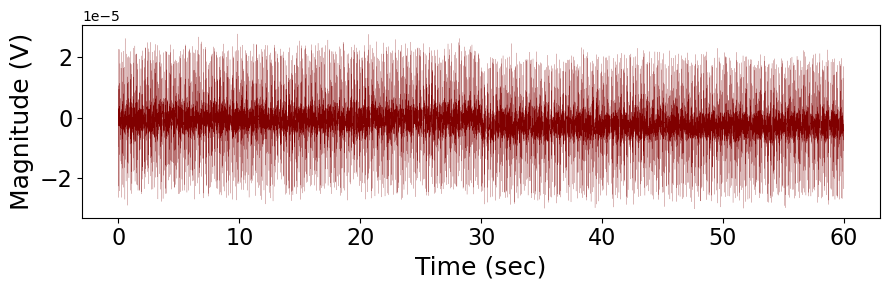

In [15]:
# Plot the SG evolution over all airspeeds and aoas
from scipy import ndimage

sensor_mapping = {0:"PZT 1", 1: "PZT 2", 2: "PZT 3", 3: "PZT 4", 4:"PZT 5", 5:"PZT 6", 6:"PZT 7",
                  7:"SG 1 (compensated)", 8: "SG 2 (compensated)", 9: "SG 4 (compensated)", 10: "SG 5 (compensated)", 11: "SG 6 (compensated)", 12: "SG LE", 13: "SG TE"}
sensor_mapping_noncomp = {0:"PZT 1", 1: "PZT 2", 2: "PZT 3", 3: "PZT 4", 4:"PZT 5", 5:"PZT 6", 6:"PZT 7",
                          7:"SG 1", 8: "SG 2", 9: "SG 4", 10: "SG 5", 11: "SG 6", 12: "SG LE", 13: "SG TE", 
                          14: "RTD 1", 15: "RTD 2", 16: "RTD 4", 17: "RTD 5", 18: "RTD 6"}

#Plot PZTs alone w/ filtering
# for i in range(0,7):
#   dat = stackedAllExamples_multidf[i,:]
  
  #Apply lowpass filter
  # sos = signal.butter(5, 2000, 'lowpass', fs=10000, output='sos')
  # dat = signal.sosfilt(sos, dat)

  #Apply median filter
  # dat = signal.medfilt(dat, 9)
  # print ("Filtering done")

#   x_axis = np.arange(0, dat.shape[0]//10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(12,3))
#   ax.plot(x_axis, dat[0:x_axis.shape[0]], 'g', label=sensor_mapping[i], linewidth=0.3)
#   ax.legend(loc='upper right', fontsize="14")
#   ax.set_ylim([-0.0008, 0.0008]) #For dataset A w/filtering
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   # ax.set_xlabel("Datapoint")
#   # ax.set_ylabel("Magnitude (V)")
#   plt.tight_layout()
#   fig.savefig(f"training_{sensor_mapping[i]}_filtered.png", dpi=300)

#Plot PZTs alone
# for i in range(6,7):
#   # mean = np.mean(stackedAllExamples_multidf[i,0:800000])
#   # dat = stackedAllExamples_multidf[i,:] - mean #For dataset B because dataset B was not already re-normalized.
#   dat = stackedAllExamples_multidf[i,:]
#   x_axis = np.arange(0, dat.shape[0]//10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(12,3))
#   ax.plot(x_axis, dat[0:x_axis.shape[0]], 'g', label=sensor_mapping[i], linewidth=0.3)
#   ax.legend(loc='upper right', fontsize="14")
#   # ax.set_ylim([-0.0008, 0.0008]) #For dataset B
#   ax.set_ylim([-0.008, 0.008]) #For dataset A (range is much larger because of RTD excitation noise)
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
#   fig.savefig(f"training_{sensor_mapping[i]}.png", dpi=300)

#Plot PZT zoomed-in
# for i in range(1,2):
#   x_range = np.arange(int(1E7),int(1.01E7)) #Zoom1-left
#   # x_range = np.arange(int(6E7),int(6.01E7)) #Zoom1-right
#   # x_range = np.arange(int(1E7),int(1.001E7)) #Zoom2,3-left
#   # x_range = np.arange(int(6E7),int(6.001E7)) #Zoom2,3-right

#   # mean = np.mean(stackedAllExamples_multidf_b[i,0:800000])
#   # dat = stackedAllExamples_multidf_b[i,x_range] - mean #For dataset B because dataset B was not already re-normalized.
#   dat = stackedAllExamples_multidf[i,x_range] #For dataset A

#   #Apply lowpass filter
#   # sos = signal.butter(5, 2000, 'lowpass', fs=10000, output='sos')
#   # dat = signal.sosfilt(sos, dat)

#   #Apply median filter
#   # dat = signal.medfilt(dat, 9)
#   # print ("Filtering done")

#   x_axis = np.arange(x_range[0]/10000, x_range[-1]/10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(6,4))
#   ax.plot(x_axis, dat[0:x_axis.shape[0]], 'g', label=sensor_mapping[i], linewidth=0.3)
#   ax.legend(loc='upper right', fontsize="14")
#   # ax.set_ylim([-0.0008, 0.0008]) #For dataset A (range is much larger because of RTD excitation noise)
#   # ax.set_ylim([-0.0008, 0.0008]) #For dataset B
#   ax.set_ylim([-0.0002, 0.0002]) #For zoom3,left (datasetA)
#   # ax.set_ylim([-0.0004, 0.0004]) #For zoom3,right (datasetA)
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
#   fig.savefig(f"training_{sensor_mapping[i]}_zoomed3.png", dpi=300)

#Plot PZT zoomed-in (filtered and unfiltered overlaid)
# for i in range(1,2):
#   x_range = np.arange(int(1E7),int(1.01E7)) #Zoom1-left
#   # x_range = np.arange(int(6E7),int(6.01E7)) #Zoom1-right
#   # x_range = np.arange(int(1E7),int(1.001E7)) #Zoom2,3-left
#   # x_range = np.arange(int(6E7),int(6.001E7)) #Zoom2,3-right

#   # mean = np.mean(stackedAllExamples_multidf_b[i,0:800000])
#   # dat = stackedAllExamples_multidf_b[i,x_range] - mean #For dataset B because dataset B was not already re-normalized.
#   dat = stackedAllExamples_multidf[i,x_range] #For dataset A

#   #Apply lowpass filter
#   # sos = signal.butter(5, 2000, 'lowpass', fs=10000, output='sos')
#   # dat = signal.sosfilt(sos, dat)

#   #Apply median filter
#   dat2 = signal.medfilt(dat, 9)
#   print ("Filtering done")

#   x_axis = np.arange(x_range[0]/10000, x_range[-1]/10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(6,4))
#   ax.plot(x_axis, dat[0:x_axis.shape[0]], 'tab:green', label=sensor_mapping[i], linewidth=0.8)
#   ax.plot(x_axis, dat2[0:x_axis.shape[0]], 'tab:purple', label=sensor_mapping[i]+" (medfilt)", linewidth=0.8)
#   ax.legend(loc='upper right', fontsize="14")
#   # ax.set_ylim([-0.0008, 0.0008]) #For dataset A (range is much larger because of RTD excitation noise)
#   # ax.set_ylim([-0.0008, 0.0008]) #For dataset B
#   # ax.set_ylim([-0.0002, 0.0002]) #For zoom3,left (datasetA)
#   ax.set_ylim([-0.0004, 0.0004]) #For zoom3,right (datasetA)
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
#   fig.savefig(f"training_{sensor_mapping[i]}_zoomed2_overlay.png", dpi=300)

#Plot PZT zoomed-in (unfiltered subtracted from filtered)
# for i in range(1,2):
#   x_range = np.arange(int(1E7),int(1.01E7)) #Zoom1-left
#   # x_range = np.arange(int(6E7),int(6.01E7)) #Zoom1-right
#   # x_range = np.arange(int(1E7),int(1.001E7)) #Zoom2,3-left
#   # x_range = np.arange(int(6E7),int(6.001E7)) #Zoom2,3-right

#   # mean = np.mean(stackedAllExamples_multidf_b[i,0:800000])
#   # dat = stackedAllExamples_multidf_b[i,x_range] - mean #For dataset B because dataset B was not already re-normalized.
#   dat = stackedAllExamples_multidf[i,x_range] #For dataset A

#   #Apply lowpass filter
#   # sos = signal.butter(5, 2000, 'lowpass', fs=10000, output='sos')
#   # dat = signal.sosfilt(sos, dat)

#   #Apply median filter
#   dat2 = signal.medfilt(dat, 9)
#   print ("Filtering done")

#   x_axis = np.arange(x_range[0]/10000, x_range[-1]/10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(6,4))
#   ax.plot(x_axis, -dat[0:x_axis.shape[0]] + dat2[0:x_axis.shape[0]], 'r', label=sensor_mapping[i]+" (diff)", linewidth=0.8)
#   ax.legend(loc='upper right', fontsize="14")
#   ax.set_ylim([-0.0008, 0.0008]) #For dataset A (range is much larger because of RTD excitation noise)
#   # ax.set_ylim([-0.0008, 0.0008]) #For dataset B
#   # ax.set_ylim([-0.0002, 0.0002]) #For zoom3,left (datasetA)
#   # ax.set_ylim([-0.0004, 0.0004]) #For zoom3,right (datasetA)
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
#   fig.savefig(f"training_{sensor_mapping[i]}_zoomed1_diff.png", dpi=300)

#Plot SGs & RTDs
# for i in range(8,11):
#   sg_comp_dat = stackedAllExamples_multidf[i,:]
#   sg_dat = stackedAllExamples_multidf_noncomp[i,:]  
#   rtd_dat = stackedAllExamples_multidf_noncomp[i+7,:]
#   if i == 11: #If we're dealing with RTD6, which is quite noisy
#       rtd_dat = ndimage.uniform_filter1d(stackedAllExamples_multidf_noncomp[i+7,:], size = 10000)

#   x_axis = np.arange(0, sg_dat.shape[0]//10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(12,3))
#   ax.plot(x_axis, sg_dat[0:x_axis.shape[0]], label=sensor_mapping_noncomp[i], linewidth=0.7)
#   ax.plot(x_axis, sg_comp_dat[0:x_axis.shape[0]], label=sensor_mapping[i], linewidth=0.7)
#   ax.plot(x_axis, rtd_dat[0:x_axis.shape[0]], 'r', label=sensor_mapping_noncomp[i+7], linewidth=0.7)
#   ax.legend(loc='lower right', fontsize="14")
#   ax.tick_params(axis="both", which="major", labelsize=13)
  
#   # plt.yticks((-6E-3, -4E-3, -2E-3, 0, 2E-3)) #For SG1 and SG6 
#   plt.yticks((-2E-3, -1E-3, 0, 1E-3)) #For SG2,4,5
#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
  
  
#   fig.savefig(f"training_{sensor_mapping_noncomp[i]}_wRTD.png", dpi=300)

#Plot SGs (wComp)
# for i in range(7,12):
#   sg_comp_dat = stackedAllExamples_multidf[i,:]
#   sg_dat = stackedAllExamples_multidf_noncomp[i,:]  
  
#   x_axis = np.arange(0, sg_dat.shape[0]//10000, 1/10000)

#   fig, ax = plt.subplots(figsize=(12,3))
#   ax.plot(x_axis, sg_dat[0:x_axis.shape[0]], label=sensor_mapping_noncomp[i], linewidth=0.7)
#   ax.plot(x_axis, sg_comp_dat[0:x_axis.shape[0]], label=sensor_mapping[i], linewidth=0.7)
#   ax.legend(loc='lower right', fontsize="14")
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.yticks((-6E-4, -4E-4, -2E-4, 0, 2E-4))
#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
#   fig.savefig(f"training_{sensor_mapping_noncomp[i]}_wcomp.png", dpi=300)

#Plot SGs (onlyComp)
# for i in range(7,12):
#   sg_comp_dat = stackedAllExamples_multidf[i,:]
  
#   x_axis = np.arange(0, sg_comp_dat.shape[0]//10000, 1/10000)
  
#   fig, ax = plt.subplots(figsize=(12,3))
#   ax.plot(x_axis, sg_comp_dat[0:x_axis.shape[0]], color='tab:orange', label=sensor_mapping[i], linewidth=0.7)
#   ax.legend(loc='lower right', fontsize="14")
#   ax.tick_params(axis="both", which="major", labelsize=13)

#   plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
#   plt.xlabel("Time (sec)", fontsize=14)
#   plt.ylabel("Magnitude (V)", fontsize=14)
#   plt.tight_layout()
  
#   fig.savefig(f"training_{sensor_mapping_noncomp[i]}.png", dpi=300)

#Plot SGs (onlyComp) zoomed-in
i = 7 #This is SG1
# x_range = np.arange(int(1E7),int(1.01E7)) #Zoom1-left
x_range = np.arange(0, int(60*1E4)) #Zoom1-left
sg_comp_dat = stackedAllExamples_multidf[i,x_range]

x_axis = np.arange(x_range[0]/10000, x_range[-1]/10000, 1/10000)

fig, ax = plt.subplots(figsize=(9,3))
ax.plot(x_axis, sg_comp_dat[0:x_axis.shape[0]], color='maroon', label=sensor_mapping[i], linewidth=0.1)
ax.tick_params(axis="both", which="major", labelsize=16)

plt.ticklabel_format(axis="y", scilimits=(0,0), style="scientific")
plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Magnitude (V)", fontsize=18)
plt.tight_layout()
fig.savefig(f"training_{sensor_mapping[i]}_zoomed1_diff.png", dpi=300)

## Plot frequency domain response of training data

In [2]:
%matplotlib widget

data_dir = os.path.join(main_dir, "MLmodels", "Training1_Jan2023", "data")
# data_dir_b = os.path.join(main_dir, "MLmodels", "Training1_B", "data")

multidf_data = np.load(os.path.join(data_dir, "sttr_aug2022_data_multidf.npy"))
# multidf_data_b = np.load(os.path.join(data_dir_b, "sttr_aug2022_data_singledf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))

allExamples_multidf = np.transpose(multidf_data[:,:,0:299600], (1,0,2)) #For usual compensated data (take first 30 seconds to match with dataset B)
# allExamples_multidf_b = np.transpose(multidf_data_b, (1,0,2)) #Clean data for PZT

# Here AllExamples_multidf.shape = (#of sensors, #of states, #reduced data per each state) (238, 14, 299600 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE'] #For usual compensated data


In [ ]:
# Experimentation block
%matplotlib widget
from scipy import ndimage
from scipy import fft
from scipy import fftpack
from scipy import log10

Fs = 1000 #Sampling frequency
T = 1/Fs #Sampling period
L = 1500 #Signal length
t = np.arange(L-1)*T #Time vector

S = 0.7*np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)
S = np.sin(2*np.pi*120*t)
# X = S + 2*np.random.randn(len(t))

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(t[0:50], S[0:50]) 
plt.xlabel("time (s)")
plt.ylabel("X")

In [ ]:
fig, ax = plt.subplots(figsize=(12,3))

Y = fft.fft(X)
P2 = abs(Y/L)
P1 = P2[0:L//2]
P1[1:-1] = 2*P1[1:-1]

f = Fs*np.arange(L//2)/L
ax.plot(f,P1) 
plt.xlabel("f (Hz)")
plt.ylabel("|P1(f)|")

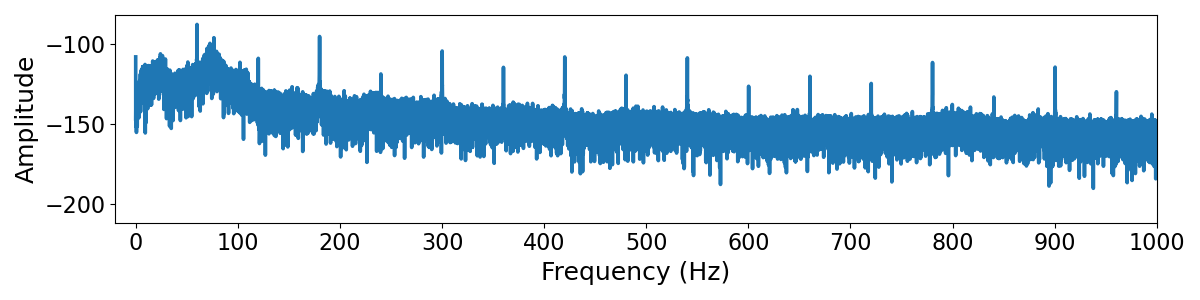

In [32]:
# Block for plotting an individual sensor's frequency response per sensor
from scipy import ndimage
from scipy import fft
from scipy import fftpack
from scipy import log10

sensor_mapping = {0:"PZT 1", 1: "PZT 2", 2: "PZT 3", 3: "PZT 4", 4:"PZT 5", 5:"PZT 6", 6:"PZT 7",
                  7:"SG 1 (compensated)", 8: "SG 2 (compensated)", 9: "SG 4 (compensated)", 10: "SG 5 (compensated)", 11: "SG 6 (compensated)", 12: "SG LE", 13: "SG TE"}

sensor_id = 1
airspeed_inc = 6 #Between 0 - 13, maps to 7 - 20
aoa_inc = 12 #Between 0 - 16, maps to 0 - 16
state_id = 17 * airspeed_inc + aoa_inc

#Get the data
dat = allExamples_multidf[sensor_id, state_id]

#Apply median filter
dat = signal.medfilt(dat, 9)

#Apply FFT on the data
dat_fft = fft.fft(dat)

#Get the usable part
P2 = abs(dat_fft/dat.shape[0])
P1 = P2[0:dat.shape[0]//2]
P1[1:-1] = 2*P1[1:-1]
# dat_fft = dat_fft[0:dat_fft.shape[0]//2]

#Get frequencies
freqs = 10000*np.arange(dat_fft.shape[0]//2)/dat_fft.shape[0]
# freqs = fftpack.fftfreq(dat.shape[0], 1/10000)
# freqs = freqs[0:freqs.shape[0]//2]

#Plot!
fig, ax = plt.subplots(figsize=(12,3))
# fig, ax = plt.subplots(figsize=(6,8)) #For plotting sample data to be put on FNO slides
# ax.plot(freqs, P1, 'tab:blue', linewidth=2.6)
ax.plot(freqs, 20*np.log10(P1), 'tab:blue', linewidth=2.6)


ax.set_xlim(-20, 1000)
# ax.set_ylim(-0.04, 0.5)
# ax.set_ylim(-4E-7, 5E-6)

plt.xlabel("Frequency (Hz)", fontsize=18)
plt.ylabel("Amplitude", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=16)

### #For plotting sample data to be put on FNO slides
# plt.xlabel("Frequency", fontsize=48)
# plt.ylabel("Amplitude", fontsize=48)
# ax.tick_params(axis="both", which="major", labelsize=0)
### ### #For plotting sample data to be put on FNO slides

plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=11)
plt.tight_layout()

In [ ]:
# Block for plotting all sensors' frequency responses 
#Define notch filters
fs = 10000.0  # Sample frequency (Hz)
f01 = 60.0 
Q1 = 6.0 
b1, a1 = signal.iirnotch(f01, Q1, fs)
notch_sos1 = signal.tf2sos(b1,a1)
# freq, h = signal.freqz(b, a, worN=4096, fs=fs) #To show the frequency response of the filter
# fig, ax1 = plt.subplots()
# ax1.plot(freq, 20 * np.log10(abs(h)), 'b')

f02 = 120.0
Q2 = 20.0
b2, a2 = signal.iirnotch(f02, Q2, fs)
notch_sos2 = signal.tf2sos(b2,a2)

f03 = 180.0
Q3 = 8.0
b3, a3 = signal.iirnotch(f03, Q3, fs)
notch_sos3 = signal.tf2sos(b3,a3)

f04 = 240.0
Q4 = 30.0
b4, a4 = signal.iirnotch(f04, Q4, fs)
notch_sos4 = signal.tf2sos(b4,a4)

f05 = 300.0
Q5 = 10.0
b5, a5 = signal.iirnotch(f05, Q5, fs)
notch_sos5 = signal.tf2sos(b5,a5)

f06 = 360.0
Q6 = 40.0
b6, a6 = signal.iirnotch(f06, Q6, fs)
notch_sos6 = signal.tf2sos(b6,a6)

f07 = 420.0
Q7 = 20.0
b7, a7 = signal.iirnotch(f07, Q7, fs)
notch_sos7 = signal.tf2sos(b7,a7)

f08 = 480.0
Q8 = 50.0
b8, a8 = signal.iirnotch(f08, Q8, fs)
notch_sos8 = signal.tf2sos(b8,a8)

f09 = 540.0
Q9 = 20.0
b9, a9 = signal.iirnotch(f09, Q9, fs)
notch_sos9 = signal.tf2sos(b9,a9)

f010 = 600.0
Q10 = 60.0
b10, a10 = signal.iirnotch(f010, Q10, fs)
notch_sos10 = signal.tf2sos(b10,a10)

f011 = 660.0
Q11 = 60.0
b11, a11 = signal.iirnotch(f011, Q11, fs)
notch_sos11 = signal.tf2sos(b11,a11)

f012 = 720.0
Q12 = 60.0
b12, a12 = signal.iirnotch(f012, Q12, fs)
notch_sos12 = signal.tf2sos(b12,a12)

f013 = 780.0
Q13 = 30
b13, a13 = signal.iirnotch(f013, Q13, fs)
notch_sos13 = signal.tf2sos(b13,a13)

f014 = 840.0
Q14 = 100.0
b14, a14 = signal.iirnotch(f014, Q14, fs)
notch_sos14 = signal.tf2sos(b14,a14)

f015 = 900.0
Q15 = 40.0
b15, a15 = signal.iirnotch(f015, Q15, fs)
notch_sos15 = signal.tf2sos(b15,a15)

f016 = 960.0
Q16 = 120.0
b16, a16 = signal.iirnotch(f016, Q16, fs)
notch_sos16 = signal.tf2sos(b16,a16)

f017 = 1020.0
Q17 = 80.0
b17, a17 = signal.iirnotch(f017, Q17, fs)
notch_sos17 = signal.tf2sos(b17,a17)

for sensor_id in range(1): #max: 7
  for airspeed_inc in range(1): #max: 14
    for aoa_inc in range(17): #max: 17
      state_id = 17 * airspeed_inc + aoa_inc

      dat = allExamples_multidf[sensor_id, state_id]

      #Apply median filter
      dat = signal.medfilt(dat, 9)

      #Apply notch filters
      dat = signal.sosfilt(notch_sos1, dat)
      dat = signal.sosfilt(notch_sos2, dat)
      dat = signal.sosfilt(notch_sos3, dat)
      dat = signal.sosfilt(notch_sos4, dat)
      dat = signal.sosfilt(notch_sos5, dat)
      dat = signal.sosfilt(notch_sos6, dat)
      dat = signal.sosfilt(notch_sos7, dat)
      dat = signal.sosfilt(notch_sos8, dat)
      dat = signal.sosfilt(notch_sos9, dat)
      dat = signal.sosfilt(notch_sos10, dat)
      dat = signal.sosfilt(notch_sos11, dat)
      dat = signal.sosfilt(notch_sos12, dat)
      dat = signal.sosfilt(notch_sos13, dat)
      dat = signal.sosfilt(notch_sos14, dat)
      dat = signal.sosfilt(notch_sos15, dat)
      dat = signal.sosfilt(notch_sos16, dat)
      dat = signal.sosfilt(notch_sos17, dat)

      #Apply FFT on the data
      dat_fft = abs(fft.fft(dat))
      
      #Get the usable part
      P2 = abs(dat_fft/dat.shape[0])
      P1 = P2[0:dat.shape[0]//2]
      P1[1:-1] = 2*P1[1:-1]
      # dat_fft = dat_fft[0:dat_fft.shape[0]//2]

      #Get frequencies
      freqs = 10000*np.arange(dat_fft.shape[0]//2)/dat_fft.shape[0]
      # freqs = fftpack.fftfreq(dat.shape[0], 1/10000)
      # freqs = freqs[0:freqs.shape[0]//2]

      dat_fft_pos = dat_fft[0:dat_fft.shape[0]//2]
      freqs_pos = freqs[0:freqs.shape[0]//2]
      
      fig, ax = plt.subplots(figsize=(12,3))
      # ax.plot(freqs, P1, 'tab:blue', linewidth=2.6)
      ax.plot(freqs, 20*np.log10(P1), 'tab:blue', linewidth=2.6)

      ax.set_xlim(-20, 1000)
      # ax.set_ylim(-0.04, 0.5) #Unscaled magnitude
      # ax.set_ylim(-4E-7, 4E-6) #Magnitude
      ax.set_ylim(-200, -100) #dB

      plt.xlabel("Frequency", fontsize=18)
      plt.ylabel("Amplitude", fontsize=18)
      ax.tick_params(axis="both", which="major", labelsize=15)

      plt.locator_params(axis='y', nbins=3)
      plt.locator_params(axis='x', nbins=11)

      plt.tight_layout()

      fig.savefig(f"mag_PZT{sensor_id+1}_vel={airspeed_inc+7}_aoa={aoa_inc}.png", dpi=300)
      # fig.savefig(f"dB_PZT{sensor_id+1}_vel={airspeed_inc+7}_aoa={aoa_inc}.png", dpi=300)
      
      plt.close()

In [198]:
#Plot 2D spectrogram

#Define notch filters
fs = 10000.0  # Sample frequency (Hz)
f01 = 60.0 
Q1 = 6.0 
b1, a1 = signal.iirnotch(f01, Q1, fs)
notch_sos1 = signal.tf2sos(b1,a1)
# freq, h = signal.freqz(b, a, worN=4096, fs=fs) #To show the frequency response of the filter
# fig, ax1 = plt.subplots()
# ax1.plot(freq, 20 * np.log10(abs(h)), 'b')

f02 = 120.0
Q2 = 20.0
b2, a2 = signal.iirnotch(f02, Q2, fs)
notch_sos2 = signal.tf2sos(b2,a2)

f03 = 180.0
Q3 = 8.0
b3, a3 = signal.iirnotch(f03, Q3, fs)
notch_sos3 = signal.tf2sos(b3,a3)

f04 = 240.0
Q4 = 30.0
b4, a4 = signal.iirnotch(f04, Q4, fs)
notch_sos4 = signal.tf2sos(b4,a4)

f05 = 300.0
Q5 = 10.0
b5, a5 = signal.iirnotch(f05, Q5, fs)
notch_sos5 = signal.tf2sos(b5,a5)

f06 = 360.0
Q6 = 40.0
b6, a6 = signal.iirnotch(f06, Q6, fs)
notch_sos6 = signal.tf2sos(b6,a6)

f07 = 420.0
Q7 = 20.0
b7, a7 = signal.iirnotch(f07, Q7, fs)
notch_sos7 = signal.tf2sos(b7,a7)

f08 = 480.0
Q8 = 50.0
b8, a8 = signal.iirnotch(f08, Q8, fs)
notch_sos8 = signal.tf2sos(b8,a8)

f09 = 540.0
Q9 = 20.0
b9, a9 = signal.iirnotch(f09, Q9, fs)
notch_sos9 = signal.tf2sos(b9,a9)

f010 = 600.0
Q10 = 60.0
b10, a10 = signal.iirnotch(f010, Q10, fs)
notch_sos10 = signal.tf2sos(b10,a10)

f011 = 660.0
Q11 = 60.0
b11, a11 = signal.iirnotch(f011, Q11, fs)
notch_sos11 = signal.tf2sos(b11,a11)

f012 = 720.0
Q12 = 60.0
b12, a12 = signal.iirnotch(f012, Q12, fs)
notch_sos12 = signal.tf2sos(b12,a12)

f013 = 780.0
Q13 = 30
b13, a13 = signal.iirnotch(f013, Q13, fs)
notch_sos13 = signal.tf2sos(b13,a13)

f014 = 840.0
Q14 = 100.0
b14, a14 = signal.iirnotch(f014, Q14, fs)
notch_sos14 = signal.tf2sos(b14,a14)

f015 = 900.0
Q15 = 40.0
b15, a15 = signal.iirnotch(f015, Q15, fs)
notch_sos15 = signal.tf2sos(b15,a15)

f016 = 960.0
Q16 = 120.0
b16, a16 = signal.iirnotch(f016, Q16, fs)
notch_sos16 = signal.tf2sos(b16,a16)

f017 = 1020.0
Q17 = 80.0
b17, a17 = signal.iirnotch(f017, Q17, fs)
notch_sos17 = signal.tf2sos(b17,a17)


# Define the data
sensor_id = 1

for airspeed in range(0,14): #range(0,14) is the most general case
  aoa_ix_start = 0 #Between 0 - 16, maps to 0 - 16
  aoa_ix_end = 16 #(inclusive) Between 0 - 16, maps to 0 - 16

  state_id_start = 17 * airspeed + aoa_ix_start
  state_id_end = 17 * airspeed + aoa_ix_end

  dat = np.stack([allExamples_multidf[0,state_id_start:state_id_end+1]], axis=1).reshape(-1,)
  # dat_len = dat.shape[0]
  # dat = dat[0:dat_len:10]

  #Apply median filter
  dat = signal.medfilt(dat, 9)

  #Apply notch filters
  dat = signal.sosfilt(notch_sos1, dat)
  dat = signal.sosfilt(notch_sos2, dat)
  dat = signal.sosfilt(notch_sos3, dat)
  dat = signal.sosfilt(notch_sos4, dat)
  dat = signal.sosfilt(notch_sos5, dat)
  dat = signal.sosfilt(notch_sos6, dat)
  dat = signal.sosfilt(notch_sos7, dat)
  dat = signal.sosfilt(notch_sos8, dat)
  dat = signal.sosfilt(notch_sos9, dat)
  dat = signal.sosfilt(notch_sos10, dat)
  dat = signal.sosfilt(notch_sos11, dat)
  dat = signal.sosfilt(notch_sos12, dat)
  dat = signal.sosfilt(notch_sos13, dat)
  dat = signal.sosfilt(notch_sos14, dat)
  dat = signal.sosfilt(notch_sos15, dat)
  dat = signal.sosfilt(notch_sos16, dat)
  dat = signal.sosfilt(notch_sos17, dat)

  fig, ax = plt.subplots(figsize=(7,3))
  spec, freqs, t, im = ax.specgram(dat, Fs=int(fs), NFFT=512, noverlap=128, scale="linear", mode='magnitude', vmin=1E-7, vmax=4E-5)
  # - spec: the periodogram ()
  # - freqs: the frequency vector
  # - t: the centers of the time bins
  # - im: the .image.AxesImage instance representing the data in the plot

  plt.xlabel("AoA", fontsize=15)
  plt.ylabel("Frequency (Hz)", fontsize=15)
  ax.tick_params(axis="both", which="major", labelsize=14)
  ax.set_ylim(0, 1000)

  x_locs = t[-1]//6 * np.arange(7)
  x_labels = (16/6 * np.arange(7)).astype('int')
  ax.set_xticks(x_locs, x_labels)

  cbar = fig.colorbar(im, format='%.0e')
  cbar.set_label("Magnitude", fontsize=15)
  cbar.ax.tick_params(labelsize=14)
  cbar.set_ticks([1e-7, 1e-5, 2e-5, 3e-5, 4e-5])

  plt.tight_layout()

  fig.savefig(f"mag_spec_PZT{sensor_id+1}_vel={airspeed+7}.png", dpi=300)

  plt.close()

NameError: name 'im' is not defined

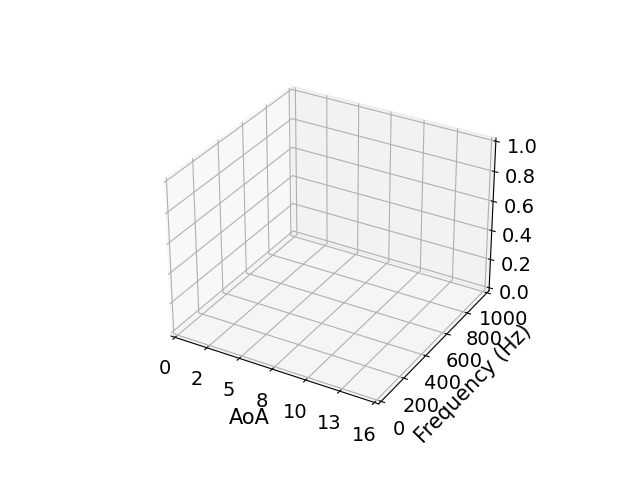

In [6]:
#Plot 3D spectrogram

#Define notch filters
fs = 10000.0  # Sample frequency (Hz)
f01 = 60.0 
Q1 = 6.0 
b1, a1 = signal.iirnotch(f01, Q1, fs)
notch_sos1 = signal.tf2sos(b1,a1)
# freq, h = signal.freqz(b, a, worN=4096, fs=fs) #To show the frequency response of the filter
# fig, ax1 = plt.subplots()
# ax1.plot(freq, 20 * np.log10(abs(h)), 'b')

f02 = 120.0
Q2 = 20.0
b2, a2 = signal.iirnotch(f02, Q2, fs)
notch_sos2 = signal.tf2sos(b2,a2)

f03 = 180.0
Q3 = 8.0
b3, a3 = signal.iirnotch(f03, Q3, fs)
notch_sos3 = signal.tf2sos(b3,a3)

f04 = 240.0
Q4 = 30.0
b4, a4 = signal.iirnotch(f04, Q4, fs)
notch_sos4 = signal.tf2sos(b4,a4)

f05 = 300.0
Q5 = 10.0
b5, a5 = signal.iirnotch(f05, Q5, fs)
notch_sos5 = signal.tf2sos(b5,a5)

f06 = 360.0
Q6 = 40.0
b6, a6 = signal.iirnotch(f06, Q6, fs)
notch_sos6 = signal.tf2sos(b6,a6)

f07 = 420.0
Q7 = 20.0
b7, a7 = signal.iirnotch(f07, Q7, fs)
notch_sos7 = signal.tf2sos(b7,a7)

f08 = 480.0
Q8 = 50.0
b8, a8 = signal.iirnotch(f08, Q8, fs)
notch_sos8 = signal.tf2sos(b8,a8)

f09 = 540.0
Q9 = 20.0
b9, a9 = signal.iirnotch(f09, Q9, fs)
notch_sos9 = signal.tf2sos(b9,a9)

f010 = 600.0
Q10 = 60.0
b10, a10 = signal.iirnotch(f010, Q10, fs)
notch_sos10 = signal.tf2sos(b10,a10)

f011 = 660.0
Q11 = 60.0
b11, a11 = signal.iirnotch(f011, Q11, fs)
notch_sos11 = signal.tf2sos(b11,a11)

f012 = 720.0
Q12 = 60.0
b12, a12 = signal.iirnotch(f012, Q12, fs)
notch_sos12 = signal.tf2sos(b12,a12)

f013 = 780.0
Q13 = 30
b13, a13 = signal.iirnotch(f013, Q13, fs)
notch_sos13 = signal.tf2sos(b13,a13)

f014 = 840.0
Q14 = 100.0
b14, a14 = signal.iirnotch(f014, Q14, fs)
notch_sos14 = signal.tf2sos(b14,a14)

f015 = 900.0
Q15 = 40.0
b15, a15 = signal.iirnotch(f015, Q15, fs)
notch_sos15 = signal.tf2sos(b15,a15)

f016 = 960.0
Q16 = 120.0
b16, a16 = signal.iirnotch(f016, Q16, fs)
notch_sos16 = signal.tf2sos(b16,a16)

f017 = 1020.0
Q17 = 80.0
b17, a17 = signal.iirnotch(f017, Q17, fs)
notch_sos17 = signal.tf2sos(b17,a17)


# Define the data
sensor_id = 1

airspeed_ix_start = 0 #Between 0 - 13, maps to 7 - 20
airspeed_ix_end = 2 #(inclusive) Between 0 - 13, maps to 7 - 20
aoa_ix_start = 0 #Between 0 - 16, maps to 0 - 16
aoa_ix_end = 16 #(inclusive) Between 0 - 16, maps to 0 - 16

state_id_start = 17 * airspeed_ix_start + aoa_ix_start
state_id_end = 17 * airspeed_ix_end + aoa_ix_end

dat = np.stack([allExamples_multidf[0,state_id_start:state_id_end+1]], axis=1).reshape(-1,)

#Apply median filter
dat = signal.medfilt(dat, 9)

#Apply notch filters
dat = signal.sosfilt(notch_sos1, dat)
dat = signal.sosfilt(notch_sos2, dat)
dat = signal.sosfilt(notch_sos3, dat)
dat = signal.sosfilt(notch_sos4, dat)
dat = signal.sosfilt(notch_sos5, dat)
dat = signal.sosfilt(notch_sos6, dat)
dat = signal.sosfilt(notch_sos7, dat)
dat = signal.sosfilt(notch_sos8, dat)
dat = signal.sosfilt(notch_sos9, dat)
dat = signal.sosfilt(notch_sos10, dat)
dat = signal.sosfilt(notch_sos11, dat)
dat = signal.sosfilt(notch_sos12, dat)
dat = signal.sosfilt(notch_sos13, dat)
dat = signal.sosfilt(notch_sos14, dat)
dat = signal.sosfilt(notch_sos15, dat)
dat = signal.sosfilt(notch_sos16, dat)
dat = signal.sosfilt(notch_sos17, dat)

# spec, freqs, t, _ = ax.specgram(dat, Fs=int(fs), NFFT=512, noverlap=128, scale="linear", mode='magnitude', vmin=1E-7, vmax=4E-5)
# - spec: the periodogram ()
# - freqs: the frequency vector
# - t: the centers of the time bins
# - im: the .image.AxesImage instance representing the data in the plot
freqs, t, spec = signal.spectrogram(dat, fs=fs, noverlap=128, nfft=512, scaling='spectrum', mode='magnitude')

ss = spec[:,np.newaxis]
ss = ss.reshape(ss.shape[0], airspeed_ix_end-airspeed_ix_start+1, -1)

fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.plot_surface(freq_bins[:, None], timestamps[None, :], 10.0*np.log10(spec), cmap=cm.coolwarm)

plt.xlabel("AoA", fontsize=15)
plt.ylabel("Frequency (Hz)", fontsize=15)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_ylim(0, 1000)

x_locs = t[-1]//6 * np.arange(7)
x_labels = (16/6 * np.arange(7)).astype('int')
ax.set_xticks(x_locs, x_labels)

cbar = fig.colorbar(im, format='%.0e')
cbar.set_label("Magnitude", fontsize=15)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([1e-7, 1e-5, 2e-5, 3e-5, 4e-5])

plt.tight_layout()

fig.savefig(f"mag_spec3D_PZT{sensor_id+1}.png", dpi=300)

## Plot same states from training and dynamic tests to investigate effect of changing conditions

In [ ]:
states=[37, 73, 141, 84]
x_axis = np.linspace(0, 0.033*1, 333*1)
fig, axs = plt.subplots(2,1, sharex=True)
for state in states:
  axs[0].plot(x_axis, multidf_data[state,10,0:333*1], linewidth=3, label="SG 5 ("+str(state_labels[state])+")")
  axs[0].legend(fontsize='x-small', loc='upper right')
  axs[0].set_ylim(-0.00015, 0.00005)
  axs[1].plot(x_axis, multidf_data[state,0,0:333*1], linewidth=0.3, label="PZT 1 ("+str(state_labels[state])+")")
  axs[1].legend(fontsize='x-small', loc='upper right')
  axs[1].set_ylim(0.0004, 0.001)

fig.set_figheight(6)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

Text(-0.05, 0.5, 'Signal (V)')

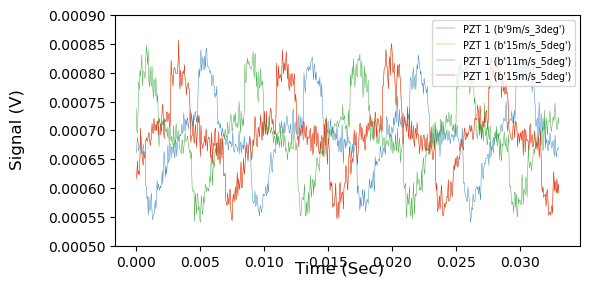

In [10]:
states=[37, 73]
x_axis = np.linspace(0, 0.033, 333*2)
fig, ax = plt.subplots(1)
for state in states:
  ax.plot(x_axis, multidf_data[state,0,0:333*2], linewidth=0.3, label="PZT 1 ("+str(state_labels[state])+")")
  ax.legend(fontsize='x-small', loc='upper right')
  ax.set_ylim(0.0005, 0.0009)
  ax.plot(x_axis, multidf_data[141,0,40:40+333*2], linewidth=0.3, label="PZT 1 ("+str(state_labels[141])+")")
  ax.legend(fontsize='x-small', loc='upper right')
  ax.set_ylim(0.0005, 0.0009)


fig.set_figheight(3)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

In [ ]:
# Plot the PZT response to observe the desync from SG/RTD.
# Best indicator is 10deg to 11deg where stall initiates
# (17m/s_10deg)(ix: 180) should happen in both
# (18m/s_10deg)(ix: 197) should happen only in singledf (because of improper concatenation)

fig, ax = plt.subplots(1)

# ax.plot(stackedAllExamples_singledf[0, int(213*299600) : int(214*299600)], linewidth=0.3) 
# ax.set_xlim(250000, 299600)
# ax.plot(stackedAllExamples_singledf[0, int(197*599200) : int(198*599200)], linewidth=0.3) 
# ax.set_xlim(480000, 560000)
# ax[1].plot(stackedAllExamples_singledf[7, int(197*599200) : int(198*599200)], linewidth=0.3)
# ax[1].set_xlim(480000, 560000)

## Investigate the dynamic run Numpy data

In [2]:
data_dir = os.path.join(main_dir, "MLmodels", "Dynamic1_Jan2023", "data")
labels_dir = os.path.join(main_dir, "MLmodels", "Dynamic1_Jan2023", "labels")

run_data = np.load(os.path.join(data_dir, "dynamic1_run15.npy"))
with open (os.path.join(labels_dir, "dynamic1_run15_truth.pkl"), "rb") as file_pi:
  state_labels_dyn = pickle.load(file_pi)

In [8]:
unique_vals = state_labels_dyn.groupby(['WT_Airspeed_int','WT_AoA_int']).size().reset_index().rename(columns={0:'count'})

In [9]:
#Print first occurrences of the columns of our interest
states_interest = [[9,3], [11,5], [15,5], [11,16]] #airspeed, AoA

for state in states_interest:
  print (state_labels_dyn[(state_labels_dyn.WT_Airspeed_int == state[0]) & (state_labels_dyn.WT_AoA_int == state[1])].first_valid_index())

2394
9843
8806
14623


Text(-0.05, 0.5, 'Signal (V)')

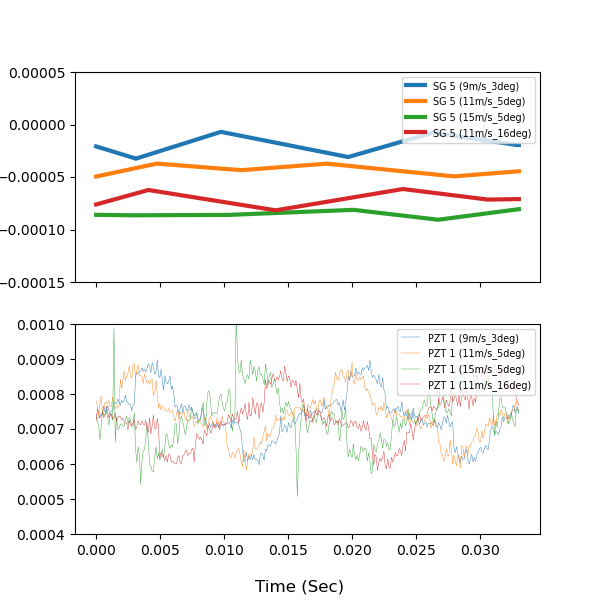

In [12]:
rows=[2394, 9843, 8806, 14623]
x_axis = np.linspace(0, 0.033*1, 333*1)
fig, axs = plt.subplots(2,1, sharex=True)

for cnt, row in enumerate(rows):
  axs[0].plot(x_axis, run_data[10,row*333:(row+1)*333], linewidth=3, label="SG 5 (" + str(states_interest[cnt][0]) + "m/s_" + str(states_interest[cnt][1]) + "deg)")
  axs[0].legend(fontsize='x-small', loc='upper right')
  axs[0].set_ylim(-0.00015, 0.00005)
  axs[1].plot(x_axis, run_data[0,row*333:(row+1)*333], linewidth=0.3, label="PZT 1 (" + str(states_interest[cnt][0]) + "m/s_" + str(states_interest[cnt][1]) + "deg)")
  axs[1].legend(fontsize='x-small', loc='upper right')
  axs[1].set_ylim(0.0004, 0.001)

fig.set_figheight(6)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

In [4]:
# Data after ML-ready conversion

# Find out parameters
sensorCount = run_data.shape[0]
lineCount = run_data.shape[1]
windowSize = 333 #(10000/30=333) Inference in every 1/30 seconds.
splitparameter = lineCount//windowSize

# Perform transformations
examplesT = run_data.T[0:windowSize*splitparameter,:]
examples = np.reshape(examplesT, (-1,windowSize,sensorCount))

In [6]:
state_labels_dyn.shape

(16115, 15)

In [15]:
print (state_labels_dyn["Video Time (sec)"][4350:4450])

4350    144.8625
4351    144.8980
4352    144.9325
4353    144.9600
4354    144.9950
          ...   
4445    148.0250
4446    148.0600
4447    148.0875
4448    148.1250
4449    148.1600
Name: Video Time (sec), Length: 100, dtype: float64


In [21]:
print (state_labels_dyn["Lift (lbf)"][4360:4387])

4360    4.640
4361    4.640
4362    4.640
4363    4.640
4364    4.670
4365    4.700
4366    4.700
4367    4.700
4368    6.580
4369    6.580
4370    6.580
4371    6.580
4372    6.580
4373    6.580
4374    6.310
4375    5.500
4376    5.500
4377    5.500
4378    5.500
4379    5.500
4380    5.500
4381    5.036
4382    4.920
4383    4.920
4384    4.920
4385    4.920
4386    4.920
Name: Lift (lbf), dtype: float64


In [18]:
%matplotlib widget

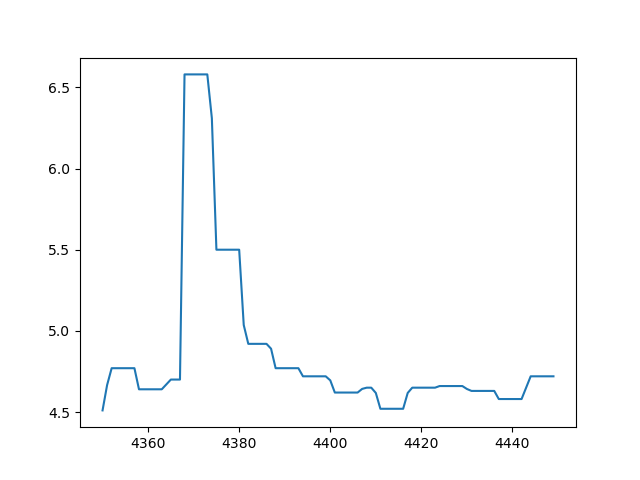

In [19]:
plt.plot(state_labels_dyn["Lift (lbf)"][4350:4450])

# Compare training and dynamic tests for same airspeed/AoA

In [2]:
train_data_dir = os.path.join(main_dir, "MLmodels", "Training1_Jan2023", "data")
dyn_data_dir = os.path.join(main_dir, "MLmodels", "Dynamic1_Jan2023", "data")
dyn_labels_dir = os.path.join(main_dir, "MLmodels", "Dynamic1_Jan2023", "labels")

train_run_data = np.load(os.path.join(train_data_dir, "sttr_aug2022_data_multidf.npy"))
dyn_run_data = np.load(os.path.join(dyn_data_dir, "dynamic1_run15.npy"))

train_state_labels = np.load(os.path.join(train_data_dir, "sttr_aug2022_statelabels.npy"))
with open (os.path.join(dyn_labels_dir, "dynamic1_run15_truth.pkl"), "rb") as file_pi:
  dyn_state_labels = pickle.load(file_pi)

Training state: b'9m/s_3deg'
Dynamic state: 9m/s_3deg


Text(-0.05, 0.5, 'Signal (V)')

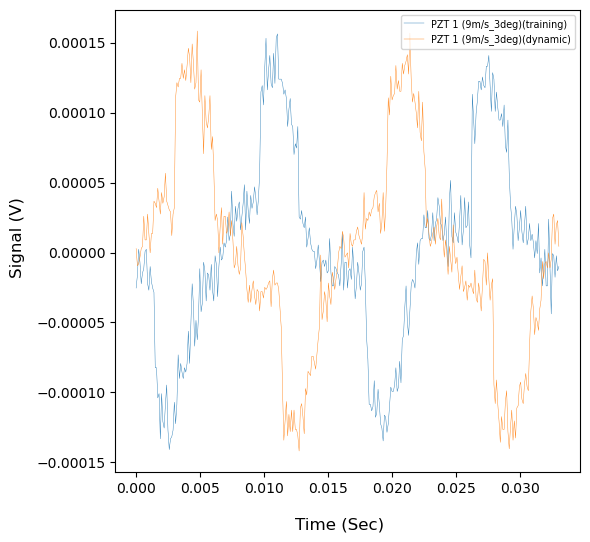

In [7]:
%matplotlib inline
# states=[37, 73, 141, 84] #All 4 states for training.
# rows=[2394, 9843, 8806, 14623] #All 4 states for dynamic
datapoints = [37, 2394]
print (f"Training state: {train_state_labels[datapoints[0]]}")

dynamic_speed = int(dyn_state_labels.loc[datapoints[1], "WT_Airspeed_int"])
dynamic_aoa = int(dyn_state_labels.loc[datapoints[1], "WT_AoA_int"])
print (f"Dynamic state: {dynamic_speed}m/s_{dynamic_aoa}deg")

x_axis = np.linspace(0, 0.033*1, 333*1)
fig, ax = plt.subplots()
ax.plot(x_axis, train_run_data[datapoints[0],0,0:333*1], linewidth=0.3, label="PZT 1 ("+str(train_state_labels[datapoints[0]])[2:-1]+")(training)")  
ax.plot(x_axis, dyn_run_data[0,datapoints[1]*333:(datapoints[1]+1)*333], linewidth=0.3, label="PZT 1 (" + str(dynamic_speed) + "m/s_" + str(dynamic_aoa) + "deg)(dynamic)")
# ax.plot(x_axis, dyn_run_data[0,datapoints[1]*333-65:(datapoints[1]+1)*333-65], linewidth=0.3, label="PZT 1 (" + str(dynamic_speed) + "m/s_" + str(dynamic_aoa) + "deg)(dynamic)(shifted)")
ax.legend(fontsize='x-small', loc='upper right')
# ax.set_ylim(0.0004, 0.001)

fig.set_figheight(6)
fig.set_figwidth(6)

fig.supxlabel('Time (Sec)')
fig.supylabel('Signal (V)', x=-0.05)

## Investigate the concatenated data from single df (backup data)

In [27]:
data_dir = os.path.join(main_dir, "KerasTraining", "Training1_B", "data")
singledf_data_backup = np.load(os.path.join(data_dir, "sttr_aug2022_data_singledf.npy"))
state_labels = np.load(os.path.join(data_dir, "sttr_aug2022_statelabels.npy"))
stackedAllExamples_singledf_frombak = np.transpose(singledf_data_backup, (1,0,2)).reshape(14, -1)

# Here data.shape = (#of states, #of sensors, #data per each state) (238, 14, 599200 for Aug. 2022 test)
# states: 7m/s_0deg, 7m/s_1deg, ... 20m/s_15deg, 20m/s_16deg.
# sensors: ['PZT 1', 'PZT 2', 'PZT 3', 'PZT 4', 'PZT 5', 'PZT 6', 'PZT 7', 'SG 1', 'SG 2', 'SG 4', 'SG 5', 'SG 6', 'SG LE', 'SG TE']
# data: 10,000sps * ~60 seconds 

In [29]:
print (singledf_data_backup.shape)
print (stackedAllExamples_singledf_frombak.shape)

(238, 14, 299600)
(14, 71304800)


Text(0.5, 0, 'Time (sec)')

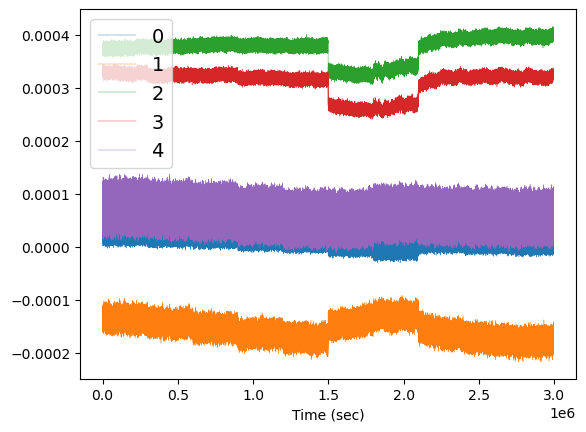

: 

In [41]:
fig, ax = plt.subplots(1)
legendkey = list()
for i in (0,1,2,3,4):
  ax.plot(stackedAllExamples_singledf_frombak[i+7,0:299600*10], linewidth=0.3)
  legendkey.append(i)
plt.legend(legendkey,loc='upper left', prop={'size':14})
plt.xlabel("Time (sec)")

# Misc. Other Investigations

In [7]:
%matplotlib widget

In [1]:
#Investigate time passed between datapoints
import datetime
# t1 = datetime.datetime(1900, 1, 1, 17, 24, 43, 50*10000) #SG/RTD data start of Day1Training1 experiment.
t1 = datetime.datetime(1900, 1, 1, 12, 38, 30, 1*10000) #SG/RTD data start of Day2Training1 experiment. 
# t1 = datetime.datetime(1900, 1, 1, 14, 32, 54, 11*10000) #SG/RTD data start of Day2Dynamic1 experiment. 
# t1 = datetime.datetime(1900, 1, 1, 17, 25, 43, 99*10000) #SG/RTD data start of Day2Training1B experiment. 
# t1 = datetime.datetime(1900, 1, 1, 17, 1, 30, 0*10000)
t2 = datetime.datetime(1900, 1, 1, 13, 5, 30, 1*10000)
# t3 = datetime.datetime(1900, 1, 1, 17, 57, 39, 82*10000)
delta = t2 - t1
print (delta)
print (delta.total_seconds())

0:27:00
1620.0
